In [1]:
# import modules
import panel as pn
pn.extension('tabulator')
import pandas as pd
import numpy as np
from panel.template import FastListTemplate
from pathlib import Path
from yahoo_fin.stock_info import get_data
import datetime
from matplotlib.figure import Figure
from matplotlib import cm
%matplotlib inline
import hvplot.pandas
import holoviews as hv
from holoviews import opts

# import modules that help build tabs
import modules.helpers as helpers
import modules.HistoricalData as hst
import modules.MCTab as MCTab
import modules.intro as intro
import modules.profile as prf

import pandas_ta as ta
import yfinance as yf


In [2]:
# use yfinance to pull ticker info. allows for hourly data
def get_stocks2(ticker_list, year=2017, month=12, day=31):

    # start = datetime.datetime(2017, 12, 31)
    start = datetime.datetime(year, month, day)
    historical_datas = {}
    for ticker in ticker_list:
        historical_datas[ticker] = get_data(ticker, start_date = start, interval="1d")

    df = []
    for ticker in ticker_list:
        dfs = historical_datas[ticker].drop('ticker', axis=1)
        df.append(dfs)
    return  pd.concat(df, axis=1, keys=ticker_list).dropna()

In [4]:
# create function to pull combined price information for a single risk-level portfolio
def get_portfolio_summary(name, start_year, start_month, start_day):
    tickers = helpers.get_ticker_by_port_name(name)
    stocks = helpers.get_stocks(tickers, start_year, start_month, start_day)
    weights = helpers.get_weights_by_name(name)
    ticker_data = stocks
    df = pd.DataFrame(np.zeros(stocks[tickers[0]].shape), columns=stocks[tickers[0]].columns, index=stocks[tickers[0]].index)
    for ticker in tickers:
        dfs = ticker_data[ticker]
        weight = weights.loc[ticker,'weight']
        dfs_weighted = dfs * weight
        df = df + dfs_weighted
        
    return df

In [5]:
df = get_portfolio_summary("conservative", 2017, 12, 31)

In [6]:
df.head()

,open,high,low,close,adjclose,volume
2018-08-15,49.566499,49.655999,49.356000,49.514001,44.941556,4375820.0
2018-08-16,49.660999,49.704000,49.480999,49.542000,44.964157,2657540.0
2018-08-17,49.509000,49.638000,49.407000,49.549000,44.970019,2549360.0
2018-08-20,49.595499,49.638000,49.465999,49.541999,44.962072,2736570.0
2018-08-21,49.625999,49.717002,49.531999,49.592000,45.009429,2400040.0


In [8]:
# add indicators to portfolio dataframe
def add_indicators(df):
    MyStrategy = ta.Strategy(
    name="custom",
    ta=[
        {"kind": "sma","length": 30},
        {"kind": "sma","length": 100},
        {"kind": "macd"},
        {"kind": "bbands", "length": 20,"std" : 2},
        {"kind": "rsi"},
        {"kind": "hlc3"},
        {"kind": "ohlc4"},
        {"kind": "linreg"},
        {"kind": "stoch"}
        
    ]
)
    df.ta.strategy(MyStrategy)
    return df

In [9]:
df = add_indicators(df)

In [10]:
df

,open,high,low,close,adjclose,volume,SMA_30,SMA_100,MACD_12_26_9,MACDh_12_26_9,...,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,HLC3,OHLC4,LR_14,STOCHk_14_3_3,STOCHd_14_3_3
2018-08-15,49.566499,49.655999,49.356000,49.514001,44.941556,4375820.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49.508667,49.523125,NaN,NaN,NaN
2018-08-16,49.660999,49.704000,49.480999,49.542000,44.964157,2657540.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49.575666,49.597000,NaN,NaN,NaN
2018-08-17,49.509000,49.638000,49.407000,49.549000,44.970019,2549360.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49.531333,49.525750,NaN,NaN,NaN
2018-08-20,49.595499,49.638000,49.465999,49.541999,44.962072,2736570.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49.548666,49.560374,NaN,NaN,NaN
2018-08-21,49.625999,49.717002,49.531999,49.592000,45.009429,2400040.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49.613667,49.616750,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29,62.036002,62.443001,61.947001,62.269000,62.225869,3264470.0,60.289134,58.788742,0.699343,0.116783,...,60.744500,63.026815,7.514474,0.833981,65.827985,62.219667,62.173751,62.374532,79.565322,81.385284
2023-03-30,62.498999,62.683999,62.284001,62.597001,62.553914,2644460.0,60.349767,58.862872,0.735721,0.122529,...,60.928250,63.185673,7.410101,0.869614,68.019816,62.521667,62.516000,62.437222,86.749914,82.022033
2023-03-31,62.564499,63.202998,62.499998,63.144998,63.101796,2914240.0,60.448334,58.937388,0.799553,0.149089,...,61.105700,63.471671,7.743862,0.930964,71.328621,62.949331,62.853123,62.618279,95.058440,87.124558
2023-04-03,62.863999,63.174999,62.645000,63.086001,63.086001,5312600.0,60.553500,59.008498,0.835746,0.148225,...,61.272000,63.702912,7.934820,0.873111,70.483127,62.968667,62.942500,62.763611,97.378620,93.062325


In [12]:
# add signals to portfolio dataframe
def add_signals(df):
    # add columns for daily returns and use those to populate a column
    # indicating buy/sell/hold based on daily performance
    df.ta.log_return(cumulative=True, append=True)
    df.ta.log_return(cumulative=False, append=True)
    df.ta.percent_return(append=True, cumulative=True)
    df.ta.percent_return(append=True, cumulative=False)
    df['performance_signal'] = 0
    df['SMA_signal'] = 0
    df['MACD_signal'] = 0
    df['BB_signal'] = 0
    sma_position = 0
    macd_position = 0
    bb_position = 0
    for index, row in df.iterrows():
        if row['PCTRET_1'] > 0:
            df.loc[index,'performance_signal'] = 1
        elif row['PCTRET_1'] < 0:
            df.loc[index,'performance_signal'] = -1
    
        # create signal column based upon SMA 
        if row['SMA_30'] > row['SMA_100'] and sma_position != 1:
            df.loc[index,'SMA_signal'] = 1
            sma_position = 1
        elif row['SMA_30'] < row['SMA_100'] and sma_position != -1:
            df.loc[index,'SMA_signal'] = -1
            sma_position = -1
            
        # create signal column based upon MACD
        if row['MACD_12_26_9'] > row['MACDs_12_26_9'] and macd_position != 1:
            df.loc[index,'MACD_signal'] = 1
            macd_position = 1
        if row['MACD_12_26_9'] < row['MACDs_12_26_9'] and macd_position != -1:
            df.loc[index,'MACD_signal'] = -1
            macd_position = -1
            
        # create signal column based upon Bollinger Bands
        if row['close'] <  row['BBL_20_2.0'] and bb_position != 1:
            df.loc[index,'BB_signal'] = 1
            bb_position = 1
        if row['close'] >  row['BBU_20_2.0'] and bb_position != -1:
            df.loc[index,'BB_signal'] = -1
            bb_position = -1
    
    return df   


In [13]:
df = add_signals(df)
df

,open,high,low,close,adjclose,volume,SMA_30,SMA_100,MACD_12_26_9,MACDh_12_26_9,...,STOCHk_14_3_3,STOCHd_14_3_3,CUMLOGRET_1,LOGRET_1,CUMPCTRET_1,PCTRET_1,performance_signal,SMA_signal,MACD_signal,BB_signal
2018-08-15,49.566499,49.655999,49.356000,49.514001,44.941556,4375820.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,0.000000,NaN,0,0,0,0
2018-08-16,49.660999,49.704000,49.480999,49.542000,44.964157,2657540.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000565,0.000565,0.000565,0.000565,1,0,0,0
2018-08-17,49.509000,49.638000,49.407000,49.549000,44.970019,2549360.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000707,0.000141,0.000707,0.000141,1,0,0,0
2018-08-20,49.595499,49.638000,49.465999,49.541999,44.962072,2736570.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000565,-0.000141,0.000565,-0.000141,-1,0,0,0
2018-08-21,49.625999,49.717002,49.531999,49.592000,45.009429,2400040.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.001574,0.001009,0.001575,0.001009,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29,62.036002,62.443001,61.947001,62.269000,62.225869,3264470.0,60.289134,58.788742,0.699343,0.116783,...,79.565322,81.385284,0.229208,0.009763,0.257604,0.009811,1,0,0,0
2023-03-30,62.498999,62.683999,62.284001,62.597001,62.553914,2644460.0,60.349767,58.862872,0.735721,0.122529,...,86.749914,82.022033,0.234462,0.005254,0.264228,0.005267,1,0,0,0
2023-03-31,62.564499,63.202998,62.499998,63.144998,63.101796,2914240.0,60.448334,58.937388,0.799553,0.149089,...,95.058440,87.124558,0.243178,0.008716,0.275296,0.008754,1,0,0,0
2023-04-03,62.863999,63.174999,62.645000,63.086001,63.086001,5312600.0,60.553500,59.008498,0.835746,0.148225,...,97.378620,93.062325,0.242243,-0.000935,0.274104,-0.000934,-1,0,0,0


In [10]:
# build data to feed to ML model for daily predictions
def build_ml_prediction_data(name, year, month, day):
    df = get_portfolio_summary(name, year - 1, month, day)
    df.ta.log_return(cumulative=True, append=True)
    df.ta.log_return(cumulative=False, append=True)
    df.ta.percent_return(append=True, cumulative=True)
    df.ta.percent_return(append=True, cumulative=False)
    df = add_indicators(df)
    df = df.dropna()
    df['performance_signal'] = 0
    for index, row in df.iterrows():
        if row['PCTRET_1'] > 0:
            df.loc[index,'performance_signal'] = 1
        elif row['PCTRET_1'] < 0:
            df.loc[index,'performance_signal'] = -1
    df = df.drop(['open', 'high', 'low', 'close', 'adjclose', 'volume','CUMLOGRET_1','LOGRET_1', 'CUMPCTRET_1', 'PCTRET_1'], axis=1)
    start = str(datetime.datetime(year, month, day).date())
    return df.loc[start:,]

In [11]:
# build dataframe showing Bollinger Bands, SMA and MACD signals and 
# dataframe used for training ML models
def build_portfolio_signal_ml_df(name, start_year, start_month, start_day):
    summary = get_portfolio_summary(name, start_year, start_month, start_day)
    indicators = add_indicators(summary)
    signals = add_signals(indicators)
    signals = signals.dropna()
    ml = signals.drop(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'SMA_signal', 'MACD_signal',
                       'BB_signal', 'CUMLOGRET_1','LOGRET_1', 'CUMPCTRET_1', 'PCTRET_1'], axis=1)
    
    return signals, ml.dropna()

In [12]:
aggressive_df, aggressive_ml = build_portfolio_signal_ml_df("aggressive", 2017,12,31)

In [13]:
aggressive_df

,open,high,low,close,adjclose,volume,SMA_30,SMA_100,MACD_12_26_9,MACDh_12_26_9,...,STOCHk_14_3_3,STOCHd_14_3_3,CUMLOGRET_1,LOGRET_1,CUMPCTRET_1,PCTRET_1,performance_signal,SMA_signal,MACD_signal,BB_signal
2018-05-24,61.115250,61.302002,60.575499,61.176502,58.085946,8228640.0,59.968742,59.684815,0.553461,0.004227,...,70.889562,73.034386,0.028859,-0.000956,0.029279,-0.000955,-1,1,0,0
2018-05-25,61.180999,61.309500,60.935501,61.099500,58.009732,6748560.0,60.046092,59.701448,0.529843,-0.015513,...,66.121126,70.963423,0.027599,-0.001259,0.027984,-0.001259,-1,0,-1,0
2018-05-29,60.909251,61.232502,60.467502,60.856002,57.778121,20881665.0,60.104742,59.711957,0.485876,-0.047584,...,51.386464,62.799051,0.023606,-0.003993,0.023887,-0.003985,-1,0,0,0
2018-05-30,61.123501,61.369501,60.898998,61.232998,58.136728,7305675.0,60.150075,59.724928,0.475966,-0.045995,...,48.953553,55.487048,0.029782,0.006176,0.030230,0.006195,1,0,0,0
2018-05-31,61.257498,61.628001,61.085998,61.280501,58.183497,11113445.0,60.194575,59.731721,0.466566,-0.044316,...,48.709344,49.683121,0.030557,0.000775,0.031029,0.000776,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29,115.799505,116.963500,115.580500,116.593999,116.583848,5490280.0,111.499634,106.715519,1.657107,0.322399,...,83.266605,82.688247,0.673794,0.018298,0.961665,0.018466,1,0,0,0
2023-03-30,117.606999,118.038498,117.034503,117.832504,117.822347,4248010.0,111.632584,106.933159,1.831761,0.397643,...,89.612902,84.524507,0.684360,0.010566,0.982502,0.010622,1,0,0,0
2023-03-31,117.710248,119.576496,117.571496,119.469496,119.459296,5760155.0,111.879368,107.149573,2.078310,0.515353,...,97.596276,90.158594,0.698157,0.013797,1.010044,0.013893,1,0,0,0
2023-04-03,118.862498,119.565497,118.271997,119.319503,119.319503,7846675.0,112.160934,107.351203,2.235825,0.538295,...,98.223822,95.144334,0.696901,-0.001256,1.007521,-0.001255,-1,0,0,0


In [77]:
conservative_df, conservative_ml = build_portfolio_signal_ml_df("conservative", 2017, 12,31)

In [138]:
display(aggressive_df.shape)
display(conservative_df.shape)

(1222, 24)

(1066, 24)

In [80]:
aggressive_ml.head()

,SMA_30,SMA_100,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,performance_signal
2018-05-24,59.968742,59.684815,0.553461,0.004227,0.549234,58.465818,60.447663,62.429508,6.557226,0.683879,-1
2018-05-25,60.046092,59.701448,0.529843,-0.015513,0.545356,58.708426,60.561438,62.414449,6.119444,0.645186,-1
2018-05-29,60.104742,59.711957,0.485876,-0.047584,0.533460,59.058610,60.675263,62.291915,5.328868,0.555899,-1
2018-05-30,60.150075,59.724928,0.475966,-0.045995,0.521961,59.354538,60.787663,62.220787,4.715182,0.655372,1
2018-05-31,60.194575,59.731721,0.466566,-0.044316,0.510882,59.772744,60.909238,62.045732,3.731762,0.663337,1


In [134]:
aggressive_ml.head()

2018-05-24   -1.0
2018-05-25   -1.0
2018-05-29    1.0
2018-05-30    1.0
2018-05-31    1.0
Name: performance_signal, dtype: float64

In [127]:
ml = build_ml_prediction_data('aggressive', 2023, 3, 30)

In [128]:
ml

,SMA_30,SMA_100,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,performance_signal
2023-03-30,111.632584,106.933159,1.831761,0.397643,1.434118,107.499729,112.869801,118.239873,9.515516,0.962070,1
2023-03-31,111.879368,107.149573,2.078310,0.515353,1.562956,107.284856,113.294301,119.303745,10.608555,1.013791,1


In [108]:
print(datetime.datetime(2023, 3, 30).date())

2023-03-30


In [118]:
start = str(datetime.datetime(2023, 3, 31).date())
ml.loc[start:,]

,SMA_30,SMA_100,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,performance_signal
2023-03-31,111.879368,107.149573,2.07831,0.515353,1.562956,107.284856,113.294301,119.303745,10.608555,1.013791,1


In [111]:
ml.tail()

,SMA_30,SMA_100,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,performance_signal
2023-03-27,111.332118,106.407149,1.574740,0.391151,1.183589,106.456709,111.678551,116.900394,9.351558,0.808555,-1
2023-03-28,111.388568,106.535579,1.536183,0.282075,1.254108,106.848677,111.981551,117.114425,9.167356,0.743377,-1
2023-03-29,111.499634,106.715519,1.657106,0.322399,1.334707,107.295422,112.422451,117.549480,9.121006,0.906819,1
2023-03-30,111.632584,106.933159,1.831761,0.397643,1.434118,107.499729,112.869801,118.239873,9.515516,0.962070,1
2023-03-31,111.879368,107.149573,2.078310,0.515353,1.562956,107.284856,113.294301,119.303745,10.608555,1.013791,1


In [65]:
aggressive_df[aggressive_df['bb_signal'] != 0]

,open,high,low,close,adjclose,volume,SMA_30,SMA_100,MACD_12_26_9,MACDh_12_26_9,...,BBB_20_2.0,BBP_20_2.0,CUMLOGRET_1,LOGRET_1,CUMPCTRET_1,PCTRET_1,performance_signal,SMA_signal,MACD_signal,BB_signal
2018-06-25,60.995752,61.249002,59.839001,60.292501,57.400454,13269040.0,61.702992,59.996028,0.122152,-0.277810,...,4.360696,-0.135684,0.014304,-0.018560,0.014406,-0.018389,-1,0,0,1
2018-08-27,63.834000,64.102000,63.660002,64.067499,60.990688,5961445.0,62.753983,61.289703,0.301573,0.088686,...,3.530920,1.098677,0.075033,0.008071,0.077920,0.008104,1,0,0,-1
2018-10-08,62.567498,62.852500,61.648499,62.345501,59.535402,14224325.0,63.727917,62.549108,-0.006504,-0.165277,...,3.253240,-0.137019,0.047787,-0.007693,0.048947,-0.007664,-1,0,0,1
2019-02-04,57.261502,57.980000,57.207499,57.958998,55.548694,5492320.0,54.827692,58.340738,0.578813,0.287628,...,7.104925,1.051673,-0.025168,0.012911,-0.024854,0.012995,1,0,0,-1
2019-05-13,63.177999,63.611501,62.433499,62.707498,60.310317,20028790.0,64.956341,59.981732,0.128462,-0.451143,...,5.395299,-0.252460,0.053577,-0.028153,0.055038,-0.027761,-1,0,0,1
2019-09-05,68.617498,69.284501,68.481503,68.966500,66.558035,7292850.0,67.314333,66.189447,0.105561,0.211330,...,4.964217,1.084200,0.148717,0.015150,0.160344,0.015266,1,0,0,-1
2019-10-02,66.894500,66.938498,65.711501,66.179499,64.032020,14179660.0,67.793640,66.687792,-0.139373,-0.229009,...,4.099799,-0.210700,0.107466,-0.016240,0.113454,-0.016108,-1,0,0,1
2019-10-25,68.673500,69.701998,68.602498,69.595999,67.337600,6993840.0,68.008823,67.542042,0.247636,0.110027,...,4.797953,1.008984,0.157803,0.014065,0.170935,0.014164,1,0,0,-1
2020-02-25,78.788601,79.078001,75.630502,75.882249,73.631683,23310835.0,80.223740,74.383275,0.452184,-0.736132,...,10.045763,-0.118569,0.244279,-0.030451,0.276700,-0.029992,-1,0,0,1
2020-05-07,76.212549,76.902502,76.099500,76.467753,74.538020,9500260.0,70.732367,74.026681,1.588604,0.364720,...,10.111982,1.015485,0.251965,0.015668,0.286551,0.015791,1,0,0,-1


:Overlay
   .Curve.I          :Curve   [index]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [index]   (value)
   .Scatter.Close.I  :Scatter   [index]   (close)
   .Scatter.Close.II :Scatter   [index]   (close)
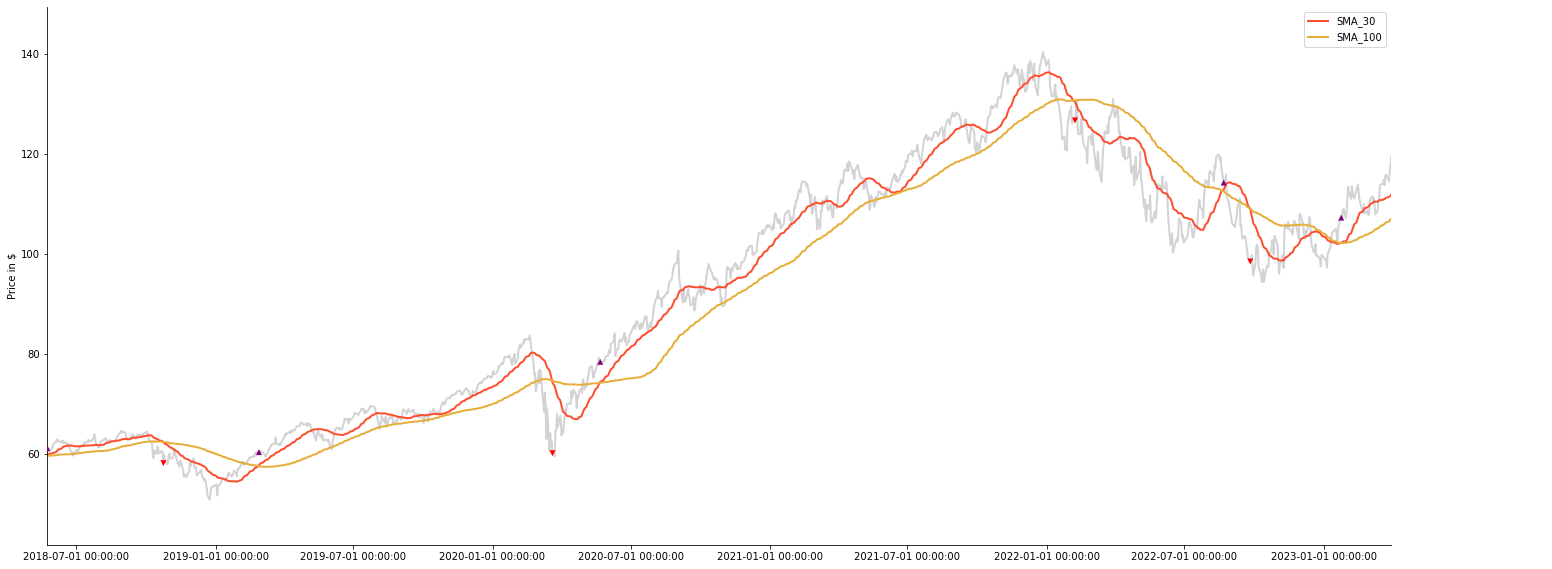

In [57]:
# plot SMA indicators

exit = aggressive_df[aggressive_df['SMA_signal'] == -1]['close'].hvplot.scatter(
    color='red',
    marker = 'v',
    legend=False,
    ylabel='Price in $',
    width=2000,
    height=800)

# Show the plot
exit

entry = aggressive_df[aggressive_df['SMA_signal'] == 1]['close'].hvplot.scatter(
    color='purple',
    marker = '^',
    legend=False,
    ylabel='Price in $',
    width=2000,
    height=800)
entry

security_close = aggressive_df[['close']].hvplot(
    color='lightgray',
    ylabel='Price in $',
    width=2000,
    height=800)
security_close

moving_avgs = aggressive_df[['SMA_30', 'SMA_100']].hvplot(
    ylabel='Price in $',
    width=2000,
    height=800)

moving_avgs

entry_exit_plot = security_close * moving_avgs * entry * exit

entry_exit_plot

:Overlay
   .Curve.I          :Curve   [index]   (close)
   .Scatter.Close.I  :Scatter   [index]   (close)
   .Scatter.Close.II :Scatter   [index]   (close)
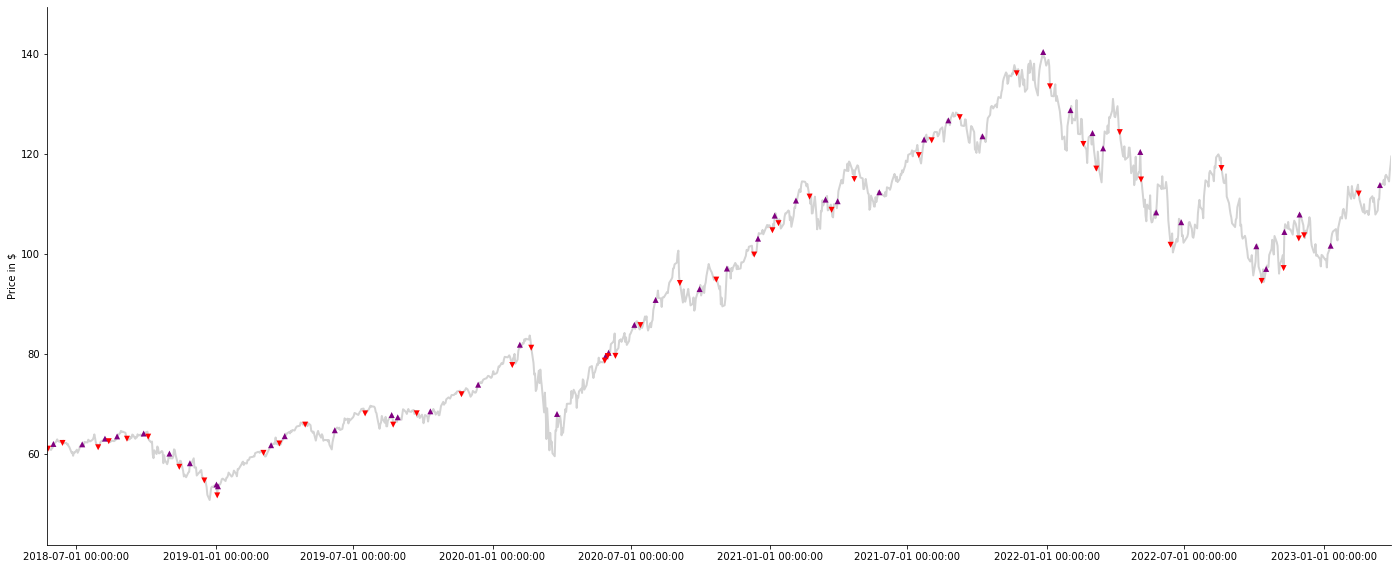

:NdOverlay   [Variable]
   :Curve   [index]   (value)
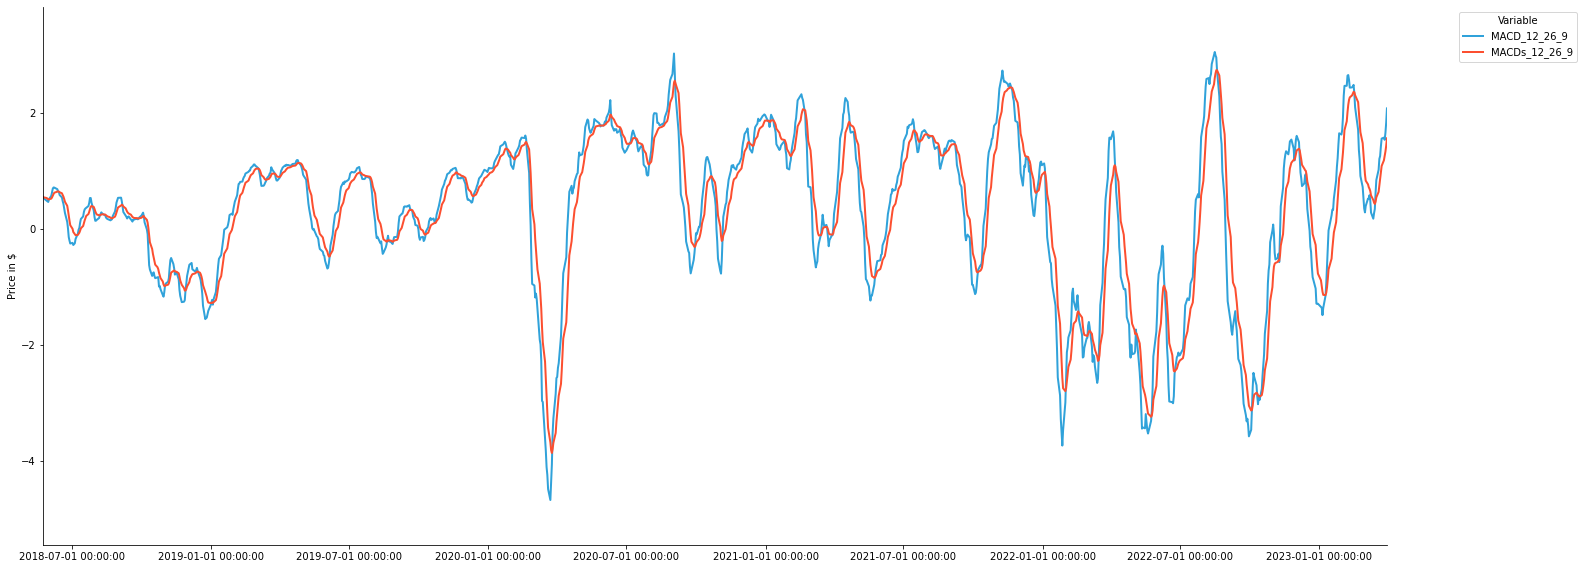

In [69]:
# plot MACD indicators

exit = aggressive_df[aggressive_df['MACD_signal'] == -1]['close'].hvplot.scatter(
    color='red',
    marker = 'v',
    legend=False,
    ylabel='Price in $',
    width=2000,
    height=800)

# Show the plot
exit

entry = aggressive_df[aggressive_df['MACD_signal'] == 1]['close'].hvplot.scatter(
    color='purple',
    marker = '^',
    legend=False,
    ylabel='Price in $',
    width=2000,
    height=800)
entry

security_close = aggressive_df[['close']].hvplot(
    color='lightgray',
    ylabel='Price in $',
    width=2000,
    height=800)
security_close

moving_avgs = aggressive_df[['MACD_12_26_9', 'MACDs_12_26_9']].hvplot(
    ylabel='Price in $',
    width=2000,
    height=800)

moving_avgs

entry_exit_plot = security_close * entry * exit

display(entry_exit_plot)
display(moving_avgs)

:Overlay
   .Curve.I          :Curve   [index]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [index]   (value)
   .Scatter.Close.I  :Scatter   [index]   (close)
   .Scatter.Close.II :Scatter   [index]   (close)
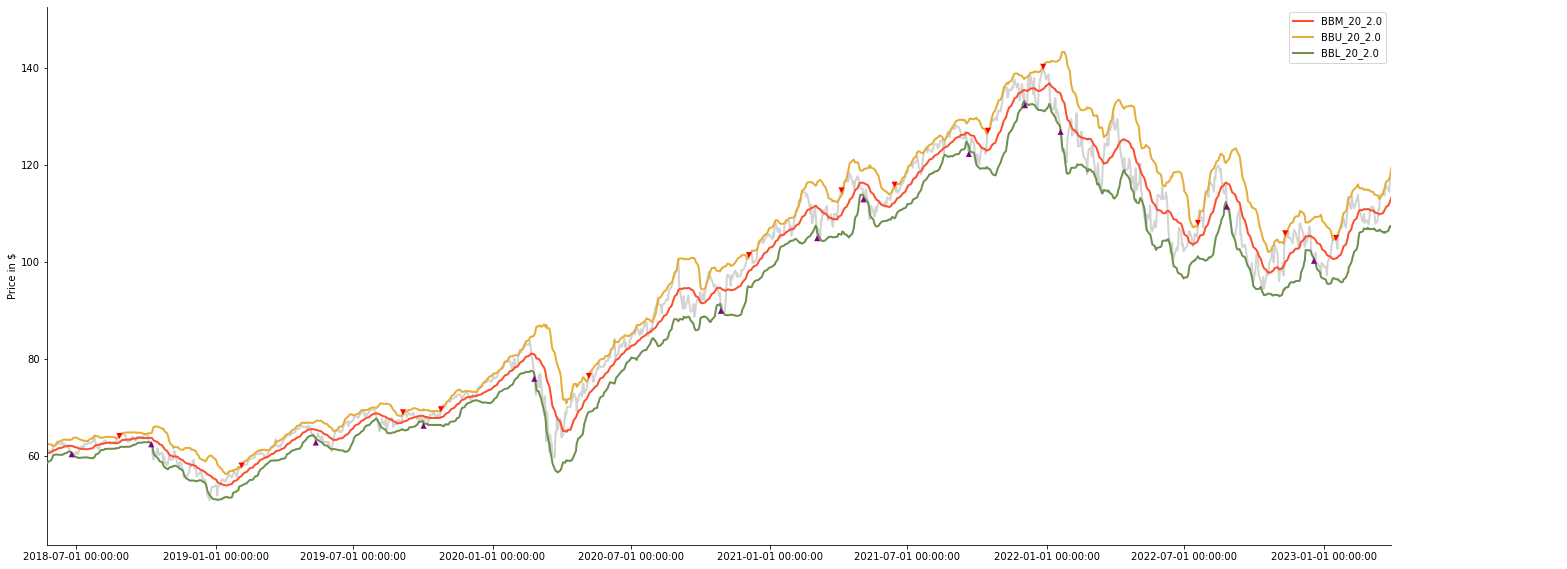

In [70]:
# plot Bollinger Band indicators

exit = aggressive_df[aggressive_df['BB_signal'] == -1]['close'].hvplot.scatter(
    color='red',
    marker = 'v',
    legend=False,
    ylabel='Price in $',
    width=2000,
    height=800)

# Show the plot
exit

entry = aggressive_df[aggressive_df['BB_signal'] == 1]['close'].hvplot.scatter(
    color='purple',
    marker = '^',
    legend=False,
    ylabel='Price in $',
    width=2000,
    height=800)
entry

security_close = aggressive_df[['close']].hvplot(
    color='lightgray',
    ylabel='Price in $',
    width=2000,
    height=800)
security_close

moving_avgs = aggressive_df[['BBM_20_2.0', 'BBU_20_2.0','BBL_20_2.0']].hvplot(
    ylabel='Price in $',
    width=2000,
    height=800)

moving_avgs

entry_exit_plot = security_close * moving_avgs * entry * exit

entry_exit_plot

In [37]:
df2 = add_indicators(conservative_df)

In [41]:
df_signals = add_signals(df2)

In [71]:
df_signals.dropna()

NameError: name 'df_signals' is not defined

In [15]:
conservative_df

,open,high,low,close,adjclose,volume
2018-08-15,49.566499,49.655999,49.356000,49.514001,44.984309,4375820.0
2018-08-16,49.660999,49.704000,49.480999,49.542000,45.006936,2657540.0
2018-08-17,49.509000,49.638000,49.407000,49.549000,45.012801,2549360.0
2018-08-20,49.595499,49.638000,49.465999,49.541999,45.004860,2736570.0
2018-08-21,49.625999,49.717002,49.531999,49.592000,45.052251,2400040.0
...,...,...,...,...,...,...
2023-03-27,62.084997,62.304998,61.661001,61.764000,61.764000,2888370.0
2023-03-28,61.707001,61.826000,61.313002,61.663999,61.663999,2359500.0
2023-03-29,62.036002,62.443001,61.947001,62.269000,62.269000,3264470.0
2023-03-30,62.498999,62.683999,62.284001,62.597001,62.597001,2644460.0


In [2]:
# getting ticker list and weights for each of the risk levels
tickers_conservative = helpers.get_tickers(12)
weights_conservative = helpers.get_weights(12)

tickers_balanced = helpers.get_tickers(20)
weights_balanced = helpers.get_weights(20)

tickers_growth = helpers.get_tickers(28)
weights_growth = helpers.get_weights(28)

tickers_aggressive = helpers.get_tickers(34)
weights_aggressive = helpers.get_weights(34)

tickers_alternative = helpers.get_tickers(40)
weights_alternative = helpers.get_weights(40)


In [3]:
stocks_conservative = helpers.get_stocks(tickers_conservative)
stocks_balanced = helpers.get_stocks(tickers_balanced)
stocks_growth = helpers.get_stocks(tickers_growth)
stocks_aggressive = helpers.get_stocks(tickers_aggressive)
stocks_alternative = helpers.get_stocks(tickers_alternative)

In [5]:
# # create function to pull combined portfolio for a single risk level
# def get_portfolio_summary(stocks, weights):
#     ticker_list = list(stocks.columns.levels[0])
#     ticker_data = stocks
#     df = pd.DataFrame(np.zeros(stocks[ticker_list[0]].shape), columns=stocks[ticker_list[0]].columns, index=stocks[ticker_list[0]].index)
#     for ticker in ticker_list:
#         dfs = ticker_data[ticker]
#         weight = weights.loc[ticker,'weight']
#         dfs_weighted = dfs * weight
#         df = df + dfs_weighted
        
#     return df
    
    

In [6]:
portfolio_conservative = get_portfolio_summary(stocks_conservative, weights_conservative)
portfolio_balanced = get_portfolio_summary(stocks_balanced, weights_balanced)
portfolio_growth = get_portfolio_summary(stocks_growth, weights_growth)
portfolio_aggressive = get_portfolio_summary(stocks_aggressive, weights_aggressive)
portfolio_alternative = get_portfolio_summary(stocks_alternative, weights_alternative)

In [7]:
# df.ta.log_return(cumulative=True, append=True)
# df.ta.log_return(cumulative=False, append=True)
# df.ta.percent_return(append=True, cumulative=True)
# df.ta.percent_return(append=True, cumulative=False)

In [8]:
# add portfolio return information and create buy/sell/hold signal
def add_signals(df):
    df.ta.log_return(cumulative=True, append=True)
    df.ta.log_return(cumulative=False, append=True)
    df.ta.percent_return(append=True, cumulative=True)
    df.ta.percent_return(append=True, cumulative=False)
    df['signal'] = 0
    for index, row in df.iterrows():
        if row['PCTRET_1'] > 0:
            df.loc[index,'signal'] = 1
        elif row['PCTRET_1'] < 0:
            df.loc[index,'signal'] = -1
    
    
    return df

In [9]:
newdf = add_signals(portfolio_conservative)
newdf

,open,high,low,close,adjclose,volume,CUMLOGRET_1,LOGRET_1,CUMPCTRET_1,PCTRET_1,signal
2018-08-15,49.566499,49.655999,49.356000,49.514001,44.984306,4375820.0,0.000000,NaN,0.000000,NaN,0
2018-08-16,49.660999,49.704000,49.480999,49.542000,45.006936,2657540.0,0.000565,0.000565,0.000565,0.000565,1
2018-08-17,49.509000,49.638000,49.407000,49.549000,45.012809,2549360.0,0.000707,0.000141,0.000707,0.000141,1
2018-08-20,49.595499,49.638000,49.465999,49.541999,45.004857,2736570.0,0.000565,-0.000141,0.000565,-0.000141,-1
2018-08-21,49.625999,49.717002,49.531999,49.592000,45.052256,2400040.0,0.001574,0.001009,0.001575,0.001009,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,62.084997,62.304998,61.661001,61.764000,61.764000,2888370.0,0.221065,-0.008480,0.247405,-0.008444,-1
2023-03-28,61.707001,61.826000,61.313002,61.663999,61.663999,2359500.0,0.219445,-0.001620,0.245385,-0.001619,-1
2023-03-29,62.036002,62.443001,61.947001,62.269000,62.269000,3264470.0,0.229208,0.009763,0.257604,0.009811,1
2023-03-30,62.498999,62.683999,62.284001,62.597001,62.597001,2644460.0,0.234462,0.005254,0.264228,0.005267,1


In [10]:
def add_indicators(df):
    MyStrategy = ta.Strategy(
    name="custom",
    ta=[
        {"kind": "sma","length": 30},
        {"kind": "sma","length": 100},
        {"kind": "macd"},
        {"kind": "bbands", "length": 20,"std" : 2}
        
    ]
)
    df.ta.strategy(MyStrategy)
    return df

In [11]:
newdf

,open,high,low,close,adjclose,volume,CUMLOGRET_1,LOGRET_1,CUMPCTRET_1,PCTRET_1,signal
2018-08-15,49.566499,49.655999,49.356000,49.514001,44.984306,4375820.0,0.000000,NaN,0.000000,NaN,0
2018-08-16,49.660999,49.704000,49.480999,49.542000,45.006936,2657540.0,0.000565,0.000565,0.000565,0.000565,1
2018-08-17,49.509000,49.638000,49.407000,49.549000,45.012809,2549360.0,0.000707,0.000141,0.000707,0.000141,1
2018-08-20,49.595499,49.638000,49.465999,49.541999,45.004857,2736570.0,0.000565,-0.000141,0.000565,-0.000141,-1
2018-08-21,49.625999,49.717002,49.531999,49.592000,45.052256,2400040.0,0.001574,0.001009,0.001575,0.001009,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,62.084997,62.304998,61.661001,61.764000,61.764000,2888370.0,0.221065,-0.008480,0.247405,-0.008444,-1
2023-03-28,61.707001,61.826000,61.313002,61.663999,61.663999,2359500.0,0.219445,-0.001620,0.245385,-0.001619,-1
2023-03-29,62.036002,62.443001,61.947001,62.269000,62.269000,3264470.0,0.229208,0.009763,0.257604,0.009811,1
2023-03-30,62.498999,62.683999,62.284001,62.597001,62.597001,2644460.0,0.234462,0.005254,0.264228,0.005267,1


In [12]:
port_summary = helpers.get_stocks(tickers_conservative)

In [13]:
ticker_list = list(port_summary.columns.levels[0])


In [14]:
ticker_list

['XLK', 'BNDX', 'GBTC', 'AAAU']

In [15]:
# pass a list of portfolio names to recieve the tickers that comprise the portfolio
def get_tickers_by_port_list(portfolios):
    tickers = []
    for port in portfolios:
        res = helpers.get_ticker_by_port_name(port)
        tickers = tickers + res
    
    return list(set(tickers))

In [16]:
ticker_list = get_tickers_by_port_list(['conservative', 'balanced', 'growth', 'aggressive','alternative'])

In [17]:
ticker_list

['GBTC', 'IVV', 'XLK', 'IEI', 'AAAU', 'REZ', 'GSG', 'USCI', 'BNDX']

In [18]:
# convert convert stock dataframe for use in ML models   
def create_ML_dataset(tickers):
    stocks = helpers.get_stocks(tickers)
    combined_df = pd.DataFrame(columns=['open', 'high','low', 'close', 'adjclose', 'volume','ticker'])
    
    for ticker in tickers:
        # df = stocks[ticker]
        df = helpers.get_stocks([ticker])
        df = df[ticker]
        df['ticker'] = ticker
        df = add_signals(df)
        df = add_indicators(df)
        combined_df = pd.concat([combined_df, df])
    combined_df.drop(['open', 'high','low', 'close', 'adjclose', 'volume', 'CUMLOGRET_1','LOGRET_1', 'CUMPCTRET_1', 'PCTRET_1'], axis=1, inplace=True)
    combined_df.set_index('ticker', append=True, inplace=True)
    
    combined_df.sort_index(inplace = True)
    return combined_df.dropna()

    


In [19]:
data = create_ML_dataset(ticker_list)

In [20]:
data

signal      SMA_30     SMA_100  MACD_12_26_9  \
           ticker                                                 
2018-05-24 BNDX       0.0   54.515334   54.339300     -0.047036   
           GBTC       1.0   14.299500   15.650433     -0.386092   
           GSG       -1.0   17.622000   16.860300      0.267434   
           IEI        1.0  119.324334  120.182000     -0.159327   
           IVV       -1.0  270.366001  272.659200      1.804715   
...                   ...         ...         ...           ...   
2023-03-31 IEI        1.0  115.814667  115.908700      0.581943   
           IVV        1.0  398.825335  398.216000      0.881580   
           REZ        1.0   70.708668   71.509800     -1.187895   
           USCI       1.0   53.773000   54.746000     -0.146913   
           XLK        1.0  140.986335  134.634201      2.711623   

                   MACDh_12_26_9  MACDs_12_26_9  BBL_20_2.0  BBM_20_2.0  \
           ticker                                                         
2018-05-24 BNDX        -0.010889      -0.036147   54.264612   54.490000   
           GBTC        -0.300654      -0.085439   12.279337   14.278250   
           GSG          0.002056       0.265378   17.212277   17.782500   
           IEI          0.061126      -0.220453  118.692020  119.184501   
           IVV          0.353502       1.451213  263.894571  271.225000   
...                          ...            ...         ...         ...   
2023-03-31 IEI          0.044037       0.537906  113.532554  116.552501   
           IVV          1.779759      -0.898179  385.827622  397.695003   
           REZ          0.303886      -1.491781   64.727837   69.234501   
           USCI         0.173546      -0.320459   52.155056   53.431000   
           XLK          0.690267       2.021356  134.975401  142.806501   

                   BBU_20_2.0  BBB_20_2.0  BBP_20_2.0  
           ticker                                      
2018-05-24 BNDX     54.715389    0.827265    0.366896  
           GBTC     16.277163   27.999412   -0.009840  
           GSG      18.352723    6.413310    0.752094  
           IEI     119.676981    0.826418    0.769550  
           IVV     278.555429    5.405423    0.740436  
...                       ...         ...         ...  
2023-03-31 IEI     119.572447    5.182123    0.681709  
           IVV     409.562383    5.968081    1.063940  
           REZ      73.741165   13.018550    0.653717  
           USCI     54.706945    4.776046    0.824857  
           XLK     150.637601   10.967428    1.023777  

[10842 rows x 11 columns]

In [8]:
weights_conservative

,weight,category
XLK,0.2,STOCKS
BNDX,0.6,BONDS
GBTC,0.1,CRYPTO
AAAU,0.1,COMMODOTIES


In [10]:
stock_weights = np.array(weights_conservative['weight'].to_list())
stock_weights

array([0.2, 0.6, 0.1, 0.1])

In [7]:
tickers_conservative

['XLK', 'BNDX', 'GBTC', 'AAAU']

In [16]:
xlk_close = stocks_conservative['XLK'][['close']]
bndx_close = stocks_conservative['BNDX'][['close']]
gbtc_close = stocks_conservative['GBTC'][['close']]
aaau_close = stocks_conservative['AAAU'][['close']]

In [15]:
xlk_close

,close
2018-08-15,72.720001
2018-08-16,73.040001
2018-08-17,73.150002
2018-08-20,73.040001
2018-08-21,73.160004
...,...
2023-03-27,144.830002
2023-03-28,144.149994
2023-03-29,147.169998
2023-03-30,148.880005


In [24]:
df = pd.concat([xlk_close, bndx_close, gbtc_close, aaau_close], axis=1)

In [26]:
df.head()

,close,close,close,close
2018-08-15,72.720001,54.720001,9.64,11.74
2018-08-16,73.040001,54.750000,9.10,11.74
2018-08-17,73.150002,54.750000,8.87,11.82
2018-08-20,73.040001,54.779999,8.76,11.90
2018-08-21,73.160004,54.799999,8.87,11.93


In [22]:
combined = pd.DataFrame(df.dot(stock_weights)).rename(columns={0: 'close'})

In [27]:
combined.head()

,close
2018-08-15,49.514001
2018-08-16,49.542000
2018-08-17,49.549000
2018-08-20,49.541999
2018-08-21,49.592000


In [29]:
mult = df * stock_weights

In [31]:
mult.sum(axis=1)

2018-08-15    49.514001
2018-08-16    49.542000
2018-08-17    49.549000
2018-08-20    49.541999
2018-08-21    49.592000
                ...    
2023-03-27    61.764000
2023-03-28    61.663999
2023-03-29    62.269000
2023-03-30    62.597001
2023-03-31    63.144998
Length: 1165, dtype: float64

In [41]:
datetime.datetime(2012, 12, 31)

datetime.datetime(2012, 12, 31, 0, 0)

In [153]:
end_date = '2023-03-30'
start_date = datetime.datetime.now() + datetime.timedelta(days=-729)
companies = ['XLK', 'BNDX', 'GBTC', 'AAAU'] 
tickers = yf.Tickers(companies)
tickers_hist = tickers.history(period='max',start = start_date, end=end_date,interval='60m',)
tickers_hist

[*********************100%***********************]  4 of 4 completed


Capital Gains                Close                        \
                             AAAU BNDX  XLK       AAAU       BNDX       GBTC   
Datetime                                                                       
2021-04-05 09:30:00           0.0  0.0  0.0  17.209999  57.084999  51.599998   
2021-04-05 10:30:00           0.0  0.0  0.0  17.230000  57.080002  52.860001   
2021-04-05 11:30:00           0.0  0.0  0.0  17.209999  57.105000  52.775002   
2021-04-05 12:30:00           0.0  0.0  0.0  17.191200  57.084999  52.270000   
2021-04-05 13:30:00           0.0  0.0  0.0  17.179899  57.099998  52.525002   
...                           ...  ...  ...        ...        ...        ...   
2023-03-29 11:30:00           0.0  0.0  0.0  19.459999  48.834999  16.020000   
2023-03-29 12:30:00           0.0  0.0  0.0  19.500000  48.845001  15.970000   
2023-03-29 13:30:00           0.0  0.0  0.0  19.520000  48.855000  15.800000   
2023-03-29 14:30:00           0.0  0.0  0.0  19.475000  48.845001  15.875000   
2023-03-29 15:30:00           0.0  0.0  0.0  19.469999  48.849998  15.870000   

                                Dividends            ...       Open  \
                            XLK      AAAU BNDX GBTC  ...       GBTC   
Datetime                                             ...              
2021-04-05 09:30:00  137.490005       0.0  0.0  0.0  ...  50.299999   
2021-04-05 10:30:00  137.580002       0.0  0.0  0.0  ...  51.610001   
2021-04-05 11:30:00  138.179993       0.0  0.0  0.0  ...  52.860001   
2021-04-05 12:30:00  138.250000       0.0  0.0  0.0  ...  52.779999   
2021-04-05 13:30:00  138.320007       0.0  0.0  0.0  ...  52.299999   
...                         ...       ...  ...  ...  ...        ...   
2023-03-29 11:30:00  146.479996       0.0  0.0  0.0  ...  16.165001   
2023-03-29 12:30:00  146.789993       0.0  0.0  0.0  ...  16.025000   
2023-03-29 13:30:00  146.600006       0.0  0.0  0.0  ...  15.960000   
2023-03-29 14:30:00  147.445007       0.0  0.0  0.0  ...  15.803300   
2023-03-29 15:30:00  147.179993       0.0  0.0  0.0  ...  15.890000   

                                Stock Splits                   Volume  \
                            XLK         AAAU BNDX GBTC  XLK      AAAU   
Datetime                                                                
2021-04-05 09:30:00  136.270004          0.0  0.0  0.0  0.0   55394.0   
2021-04-05 10:30:00  137.500000          0.0  0.0  0.0  0.0   54380.0   
2021-04-05 11:30:00  137.570007          0.0  0.0  0.0  0.0    9574.0   
2021-04-05 12:30:00  138.199997          0.0  0.0  0.0  0.0   75835.0   
2021-04-05 13:30:00  138.259995          0.0  0.0  0.0  0.0   11965.0   
...                         ...          ...  ...  ...  ...       ...   
2023-03-29 11:30:00  146.279999          0.0  0.0  0.0  0.0  220773.0   
2023-03-29 12:30:00  146.479996          0.0  0.0  0.0  0.0  165496.0   
2023-03-29 13:30:00  146.779999          0.0  0.0  0.0  0.0  115137.0   
2023-03-29 14:30:00  146.610001          0.0  0.0  0.0  0.0  180632.0   
2023-03-29 15:30:00  147.440002          0.0  0.0  0.0  0.0  101050.0   

                                                     
                         BNDX       GBTC        XLK  
Datetime                                             
2021-04-05 09:30:00  623227.0        0.0  1292083.0  
2021-04-05 10:30:00  467584.0  2621864.0   759927.0  
2021-04-05 11:30:00  414510.0  1556124.0   729235.0  
2021-04-05 12:30:00  748151.0   975945.0   555144.0  
2021-04-05 13:30:00  411824.0   708557.0   458066.0  
...                       ...        ...        ...  
2023-03-29 11:30:00  282756.0   397937.0   915655.0  
2023-03-29 12:30:00  237462.0   196844.0   417074.0  
2023-03-29 13:30:00  347040.0   269073.0   658668.0  
2023-03-29 14:30:00  334079.0   230333.0  1315233.0  
2023-03-29 15:30:00  233845.0   191375.0  1560200.0  

[3500 rows x 31 columns]

In [229]:
new_df = tickers_hist.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index(level=1)

In [230]:
new_df.head()

,Ticker,Capital Gains,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,,,
2021-04-05 09:30:00,AAAU,0.0,17.209999,0.0,17.213301,17.150000,17.160000,0.0,55394.0
2021-04-05 09:30:00,BNDX,0.0,57.084999,0.0,57.090000,57.029999,57.070000,0.0,623227.0
2021-04-05 09:30:00,GBTC,NaN,51.599998,0.0,51.610001,50.049999,50.299999,0.0,0.0
2021-04-05 09:30:00,XLK,0.0,137.490005,0.0,137.539993,136.089996,136.270004,0.0,1292083.0
2021-04-05 10:30:00,AAAU,0.0,17.230000,0.0,17.235001,17.170000,17.208200,0.0,54380.0


In [231]:
df_merged = pd.DataFrame(columns=['Ticker', 'Capital Gains', 'Close', 'Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'Volume'])
for company in companies:
    df = new_df[new_df['Ticker'] == company]
    df_merged = pd.concat([df_merged, df], axis=1)


In [232]:
df_merged

,Ticker,Capital Gains,Close,Dividends,High,Low,Open,Stock Splits,Volume,Ticker,...,Volume,Ticker,Capital Gains,Close,Dividends,High,Low,Open,Stock Splits,Volume
2021-04-05 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XLK,...,0.0,AAAU,0.0,17.209999,0.0,17.213301,17.150000,17.160000,0.0,55394.0
2021-04-05 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XLK,...,2621864.0,AAAU,0.0,17.230000,0.0,17.235001,17.170000,17.208200,0.0,54380.0
2021-04-05 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XLK,...,1556124.0,AAAU,0.0,17.209999,0.0,17.250000,17.209999,17.231899,0.0,9574.0
2021-04-05 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XLK,...,975945.0,AAAU,0.0,17.191200,0.0,17.217899,17.190001,17.217899,0.0,75835.0
2021-04-05 13:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XLK,...,708557.0,AAAU,0.0,17.179899,0.0,17.180000,17.168800,17.178699,0.0,11965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XLK,...,196844.0,AAAU,0.0,19.500000,0.0,19.500000,19.464001,19.469101,0.0,165496.0
2023-03-29 13:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XLK,...,269073.0,AAAU,0.0,19.520000,0.0,19.530001,19.510000,19.510000,0.0,115137.0
2023-03-29 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XLK,...,230333.0,AAAU,0.0,19.475000,0.0,19.525999,19.469999,19.514999,0.0,180632.0
2023-03-29 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XLK,...,191375.0,AAAU,0.0,19.469999,0.0,19.485001,19.450100,19.475000,0.0,101050.0


In [ ]:
datetime.now() + timedelta(days=1,minutes=5) 

In [186]:
columns = pd.MultiIndex.from_arrays([['a1','a1','a2','a2'], ['b1','b2','b3','b4']])
index = pd.MultiIndex.from_tuples([(0,'c1','d1'), (0, 'c2', 'd3')])
df = pd.DataFrame(np.arange(1,9).reshape(2,-1), columns=columns, index=index)

In [188]:
df

a1    a2   
        b1 b2 b3 b4
0 c1 d1  1  2  3  4
  c2 d3  5  6  7  8

In [189]:
df.unstack(level=1)#.reorder_levels([2,0,1], axis=1)

a1                  a2               
       b1        b2        b3        b4     
       c1   c2   c1   c2   c1   c2   c1   c2
0 d1  1.0  NaN  2.0  NaN  3.0  NaN  4.0  NaN
  d3  NaN  5.0  NaN  6.0  NaN  7.0  NaN  8.0

In [190]:
df.unstack(level=1).reorder_levels([2,0,1], axis=1)

c1   c2   c1   c2   c1   c2   c1   c2
       a1   a1   a1   a1   a2   a2   a2   a2
       b1   b1   b2   b2   b3   b3   b4   b4
0 d1  1.0  NaN  2.0  NaN  3.0  NaN  4.0  NaN
  d3  NaN  5.0  NaN  6.0  NaN  7.0  NaN  8.0

In [233]:
updated_df = new_df.reset_index().set_index(['Date', 'Ticker'])

In [234]:
updated_df.drop(['Capital Gains', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
reordered_df = updated_df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [241]:
reordered_df

Open        High         Low       Close  \
Date                Ticker                                                   
2021-04-05 09:30:00 AAAU     17.160000   17.213301   17.150000   17.209999   
                    BNDX     57.070000   57.090000   57.029999   57.084999   
                    GBTC     50.299999   51.610001   50.049999   51.599998   
                    XLK     136.270004  137.539993  136.089996  137.490005   
2021-04-05 10:30:00 AAAU     17.208200   17.235001   17.170000   17.230000   
...                                ...         ...         ...         ...   
2023-03-29 14:30:00 XLK     146.610001  147.470001  146.570007  147.445007   
2023-03-29 15:30:00 AAAU     19.475000   19.485001   19.450100   19.469999   
                    BNDX     48.845001   48.849998   48.840000   48.849998   
                    GBTC     15.890000   15.890000   15.790000   15.870000   
                    XLK     147.440002  147.500000  147.024994  147.179993   

                               Volume  
Date                Ticker             
2021-04-05 09:30:00 AAAU      55394.0  
                    BNDX     623227.0  
                    GBTC          0.0  
                    XLK     1292083.0  
2021-04-05 10:30:00 AAAU      54380.0  
...                               ...  
2023-03-29 14:30:00 XLK     1315233.0  
2023-03-29 15:30:00 AAAU     101050.0  
                    BNDX     233845.0  
                    GBTC     191375.0  
                    XLK     1560200.0  

[13996 rows x 5 columns]

In [248]:
final_df = reordered_df.unstack(level=1).reorder_levels([1,0], axis=1).sort_index(axis=1, level='Ticker',sort_remaining=False)

In [249]:
final_df

Ticker                    AAAU                                             \
                          Open       High        Low      Close    Volume   
Date                                                                        
2021-04-05 09:30:00  17.160000  17.213301  17.150000  17.209999   55394.0   
2021-04-05 10:30:00  17.208200  17.235001  17.170000  17.230000   54380.0   
2021-04-05 11:30:00  17.231899  17.250000  17.209999  17.209999    9574.0   
2021-04-05 12:30:00  17.217899  17.217899  17.190001  17.191200   75835.0   
2021-04-05 13:30:00  17.178699  17.180000  17.168800  17.179899   11965.0   
...                        ...        ...        ...        ...       ...   
2023-03-29 11:30:00  19.510000  19.520000  19.450001  19.459999  220773.0   
2023-03-29 12:30:00  19.469101  19.500000  19.464001  19.500000  165496.0   
2023-03-29 13:30:00  19.510000  19.530001  19.510000  19.520000  115137.0   
2023-03-29 14:30:00  19.514999  19.525999  19.469999  19.475000  180632.0   
2023-03-29 15:30:00  19.475000  19.485001  19.450100  19.469999  101050.0   

Ticker                    BNDX                                             \
                          Open       High        Low      Close    Volume   
Date                                                                        
2021-04-05 09:30:00  57.070000  57.090000  57.029999  57.084999  623227.0   
2021-04-05 10:30:00  57.082802  57.090000  57.080002  57.080002  467584.0   
2021-04-05 11:30:00  57.084999  57.119999  57.080002  57.105000  414510.0   
2021-04-05 12:30:00  57.105000  57.110001  57.080002  57.084999  748151.0   
2021-04-05 13:30:00  57.084999  57.099998  57.080002  57.099998  411824.0   
...                        ...        ...        ...        ...       ...   
2023-03-29 11:30:00  48.875000  48.889702  48.821301  48.834999  282756.0   
2023-03-29 12:30:00  48.834999  48.875000  48.830002  48.845001  237462.0   
2023-03-29 13:30:00  48.845001  48.869999  48.840000  48.855000  347040.0   
2023-03-29 14:30:00  48.855000  48.860001  48.830002  48.845001  334079.0   
2023-03-29 15:30:00  48.845001  48.849998  48.840000  48.849998  233845.0   

Ticker                    GBTC                                              \
                          Open       High        Low      Close     Volume   
Date                                                                         
2021-04-05 09:30:00  50.299999  51.610001  50.049999  51.599998        0.0   
2021-04-05 10:30:00  51.610001  52.889999  51.540001  52.860001  2621864.0   
2021-04-05 11:30:00  52.860001  53.000000  52.430000  52.775002  1556124.0   
2021-04-05 12:30:00  52.779999  52.840000  52.029999  52.270000   975945.0   
2021-04-05 13:30:00  52.299999  52.560001  52.040001  52.525002   708557.0   
...                        ...        ...        ...        ...        ...   
2023-03-29 11:30:00  16.165001  16.219999  15.950000  16.020000   397937.0   
2023-03-29 12:30:00  16.025000  16.040001  15.830000  15.970000   196844.0   
2023-03-29 13:30:00  15.960000  15.970000  15.780000  15.800000   269073.0   
2023-03-29 14:30:00  15.803300  15.920000  15.800000  15.875000   230333.0   
2023-03-29 15:30:00  15.890000  15.890000  15.790000  15.870000   191375.0   

Ticker                      XLK                                                 
                           Open        High         Low       Close     Volume  
Date                                                                            
2021-04-05 09:30:00  136.270004  137.539993  136.089996  137.490005  1292083.0  
2021-04-05 10:30:00  137.500000  137.830002  137.369995  137.580002   759927.0  
2021-04-05 11:30:00  137.570007  138.199997  137.539993  138.179993   729235.0  
2021-04-05 12:30:00  138.199997  138.360001  138.139999  138.250000   555144.0  
2021-04-05 13:30:00  138.259995  138.470001  138.125000  138.320007   458066.0  
...                         ...         ...         ...         ...        ...  
2023-03-29 11:30:00 

In [223]:
new_df

Ticker                    AAAU                                             \
                         Close       High        Low       Open    Volume   
Date                                                                        
2021-04-05 09:30:00  17.209999  17.213301  17.150000  17.160000   55394.0   
2021-04-05 10:30:00  17.230000  17.235001  17.170000  17.208200   54380.0   
2021-04-05 11:30:00  17.209999  17.250000  17.209999  17.231899    9574.0   
2021-04-05 12:30:00  17.191200  17.217899  17.190001  17.217899   75835.0   
2021-04-05 13:30:00  17.179899  17.180000  17.168800  17.178699   11965.0   
...                        ...        ...        ...        ...       ...   
2023-03-29 11:30:00  19.459999  19.520000  19.450001  19.510000  220773.0   
2023-03-29 12:30:00  19.500000  19.500000  19.464001  19.469101  165496.0   
2023-03-29 13:30:00  19.520000  19.530001  19.510000  19.510000  115137.0   
2023-03-29 14:30:00  19.475000  19.525999  19.469999  19.514999  180632.0   
2023-03-29 15:30:00  19.469999  19.485001  19.450100  19.475000  101050.0   

Ticker                    BNDX                                             \
                         Close       High        Low       Open    Volume   
Date                                                                        
2021-04-05 09:30:00  57.084999  57.090000  57.029999  57.070000  623227.0   
2021-04-05 10:30:00  57.080002  57.090000  57.080002  57.082802  467584.0   
2021-04-05 11:30:00  57.105000  57.119999  57.080002  57.084999  414510.0   
2021-04-05 12:30:00  57.084999  57.110001  57.080002  57.105000  748151.0   
2021-04-05 13:30:00  57.099998  57.099998  57.080002  57.084999  411824.0   
...                        ...        ...        ...        ...       ...   
2023-03-29 11:30:00  48.834999  48.889702  48.821301  48.875000  282756.0   
2023-03-29 12:30:00  48.845001  48.875000  48.830002  48.834999  237462.0   
2023-03-29 13:30:00  48.855000  48.869999  48.840000  48.845001  347040.0   
2023-03-29 14:30:00  48.845001  48.860001  48.830002  48.855000  334079.0   
2023-03-29 15:30:00  48.849998  48.849998  48.840000  48.845001  233845.0   

Ticker                    GBTC                                              \
                         Close       High        Low       Open     Volume   
Date                                                                         
2021-04-05 09:30:00  51.599998  51.610001  50.049999  50.299999        0.0   
2021-04-05 10:30:00  52.860001  52.889999  51.540001  51.610001  2621864.0   
2021-04-05 11:30:00  52.775002  53.000000  52.430000  52.860001  1556124.0   
2021-04-05 12:30:00  52.270000  52.840000  52.029999  52.779999   975945.0   
2021-04-05 13:30:00  52.525002  52.560001  52.040001  52.299999   708557.0   
...                        ...        ...        ...        ...        ...   
2023-03-29 11:30:00  16.020000  16.219999  15.950000  16.165001   397937.0   
2023-03-29 12:30:00  15.970000  16.040001  15.830000  16.025000   196844.0   
2023-03-29 13:30:00  15.800000  15.970000  15.780000  15.960000   269073.0   
2023-03-29 14:30:00  15.875000  15.920000  15.800000  15.803300   230333.0   
2023-03-29 15:30:00  15.870000  15.890000  15.790000  15.890000   191375.0   

Ticker                      XLK                                                 
                          Close        High         Low        Open     Volume  
Date                                                                            
2021-04-05 09:30:00  137.490005  137.539993  136.089996  136.270004  1292083.0  
2021-04-05 10:30:00  137.580002  137.830002  137.369995  137.500000   759927.0  
2021-04-05 11:30:00  138.179993  138.199997  137.539993  137.570007   729235.0  
2021-04-05 12:30:00  138.250000  138.360001  138.139999  138.199997   555144.0  
2021-04-05 13:30:00  138.320007  138.470001  138.125000  138.259995   458066.0  
...                         ...         ...         ...         ...        ...  
2023-03-29 11:30:00 